In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy

In [ ]:
import requests

collection_name = "Adrenal-ACC-Ki67-Seg"
url = f"https://services.cancerimagingarchive.net/services/v4/TCIA/query/getPatientStudy?Collection={collection_name}"

response = requests.get(url)
if response.status_code == 200:
    data = response.json()
    # Assuming 'data' is a list of dictionaries
    df = pd.DataFrame(data)
else:
    print("Failed to retrieve data for collection:", collection_name)

In [ ]:
df.head()

,Collection,PatientID,PatientName,PatientSex,StudyInstanceUID,StudyDate,StudyDescription,PatientAge,SeriesCount
0,Adrenal-ACC-Ki67-Seg,Adrenal_Ki67_Seg_010,Adrenal_Ki67_Seg_010,F,1.3.6.1.4.1.14519.5.2.1.2646787526776982040973...,2005-09-20,CT ABDOMEN,036Y,4
1,Adrenal-ACC-Ki67-Seg,Adrenal_Ki67_Seg_052,Adrenal_Ki67_Seg_052,F,1.3.6.1.4.1.14519.5.2.1.1299074335453809301156...,2013-05-14,CT CHEST ABDOMEN PELVIS W WO CONTRAST,054Y,2
2,Adrenal-ACC-Ki67-Seg,Adrenal_Ki67_Seg_052,Adrenal_Ki67_Seg_052,F,1.3.6.1.4.1.14519.5.2.1.1730992308497526744097...,2013-05-14,CT CHEST ABDOMEN PELVIS W WO CONTRAST,NaN,2
3,Adrenal-ACC-Ki67-Seg,Adrenal_Ki67_Seg_035,Adrenal_Ki67_Seg_035,F,1.3.6.1.4.1.14519.5.2.1.3275654464077781587728...,2009-11-17,CT Abdomen,046Y,4
4,Adrenal-ACC-Ki67-Seg,Adrenal_Ki67_Seg_011,Adrenal_Ki67_Seg_011,F,1.3.6.1.4.1.14519.5.2.1.3259446941461280897500...,2005-11-29,CT ABD/PELVIS-W,066Y,2


## Data Extraction

In [ ]:
import requests
import pandas as pd

# Base URL for the TCIA API
base_url = "https://services.cancerimagingarchive.net/services/v4/TCIA"

# Iterate through each row in the DataFrame to get StudyInstanceUIDs
for index, row in df.iterrows():
    study_instance_uid = row['StudyInstanceUID']
    patient_id = row['PatientID']

    # Construct the URL for the getSeries query
    series_query_url = f"{base_url}/query/getSeries?StudyInstanceUID={study_instance_uid}&format=json"

    # Send the request to get series details
    series_response = requests.get(series_query_url)
    if series_response.status_code == 200:
        series_data = series_response.json()

        # Assume series_data is a list of dictionaries, each containing a SeriesInstanceUID
        for series in series_data:
            series_instance_uid = series['SeriesInstanceUID']

            # Construct the URL for the getImage query using SeriesInstanceUID
            image_query_url = f"{base_url}/query/getImage?SeriesInstanceUID={series_instance_uid}&format=zip"

            # Download images for the series
            image_response = requests.get(image_query_url)
            if image_response.status_code == 200:
                with open(f"{patient_id}_{series_instance_uid}.zip", "wb") as zip_file:
                    zip_file.write(image_response.content)
                print(f"Downloaded images for {patient_id}, series {series_instance_uid}.")
            else:
                print(f"Failed to download images for series {series_instance_uid}.")
    else:
        print(f"Failed to retrieve series for study {study_instance_uid}.")

Downloaded images for Adrenal_Ki67_Seg_010, series 1.3.6.1.4.1.14519.5.2.1.281516401446046785642626111827183313084.
Downloaded images for Adrenal_Ki67_Seg_010, series 1.3.6.1.4.1.14519.5.2.1.78902398934725445451810327589285033056.
Downloaded images for Adrenal_Ki67_Seg_010, series 1.3.6.1.4.1.14519.5.2.1.69274290738615363420785872757873889471.
Downloaded images for Adrenal_Ki67_Seg_010, series 1.3.6.1.4.1.14519.5.2.1.36780218254248931533813640123235922004.
Downloaded images for Adrenal_Ki67_Seg_052, series 1.3.6.1.4.1.14519.5.2.1.87096534736662832326012691552928501130.
Downloaded images for Adrenal_Ki67_Seg_052, series 1.3.6.1.4.1.14519.5.2.1.93749976419998592224114178281260117123.
Downloaded images for Adrenal_Ki67_Seg_052, series 1.3.6.1.4.1.14519.5.2.1.17028505331049878840083499779200766676.
Downloaded images for Adrenal_Ki67_Seg_052, series 1.3.6.1.4.1.14519.5.2.1.212828723750866851671260767484226848086.
Downloaded images for Adrenal_Ki67_Seg_035, series 1.3.6.1.4.1.14519.5.2.1.606

## Data preprocessing

In [ ]:
from sklearn.preprocessing import LabelEncoder
import numpy as np
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.losses import mse
from tensorflow.keras import backend as K

for column in df.select_dtypes(include=['object']).columns:
    df[column] = LabelEncoder().fit_transform(df[column])

# Split data into features (X) and drop columns not relevant for VAE processing
X = df.drop(['PatientID', 'PatientName', 'StudyInstanceUID'], axis=1).values

# VAE parameters
input_dim = X.shape[1]
intermediate_dim = 64
latent_dim = 2

# VAE model, assuming a simple architecture
inputs = Input(shape=(input_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.0)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(input_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)

# VAE model
vae = Model(inputs, x_decoded_mean)

# Loss function
reconstruction_loss = mse(inputs, x_decoded_mean) * input_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')


In [ ]:
pip install pydicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 13.7 MB/s eta 0:00:00


In [ ]:
!pip install torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 32.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 65.4 MB/s eta 0:00:00


In [ ]:
import os
import pydicom
from PIL import Image
import numpy as np

# Assuming your DICOM files are stored in the current directory, which is '/content' in Colab
# List all DICOM files in the directory with names from ID_0000 to ID_0099
dicom_files = [f for f in os.listdir('/content') if f.endswith('.dcm') and 'ID_' in f]
extracted_files = [f for f in dicom_files if int(f.split('_')[1]) in range(100)]

# Let's print out the names of the files to be processed
print("Files processed:")
print(extracted_files)

# Now let's define a preprocessing function:
def preprocess_dicom(dicom_path):
    dicom_image = pydicom.dcmread(dicom_path)
    image = Image.fromarray(dicom_image.pixel_array)
    image = image.resize((256, 256))  # Resize image to 256x256 pixels
    image_array = np.array(image)
    image_array = image_array / np.max(image_array)  # Normalize image array to [0, 1]
    # Ensure that there are 3 channels if the VAE expects color images
    if image_array.ndim == 2:
        image_array = np.stack((image_array,)*3, axis=-1)
    return image_array

# Now let's preprocess the images
preprocessed_images = [preprocess_dicom(f'/content/{file}') for file in extracted_files]


Files processed:
['ID_0086_AGE_0073_CONTRAST_0_CT.dcm', 'ID_0007_AGE_0061_CONTRAST_1_CT.dcm', 'ID_0057_AGE_0049_CONTRAST_0_CT.dcm', 'ID_0090_AGE_0067_CONTRAST_0_CT.dcm', 'ID_0081_AGE_0058_CONTRAST_0_CT.dcm', 'ID_0049_AGE_0061_CONTRAST_1_CT.dcm', 'ID_0070_AGE_0074_CONTRAST_0_CT.dcm', 'ID_0035_AGE_0059_CONTRAST_1_CT.dcm', 'ID_0011_AGE_0061_CONTRAST_1_CT.dcm', 'ID_0092_AGE_0072_CONTRAST_0_CT.dcm', 'ID_0005_AGE_0048_CONTRAST_1_CT.dcm', 'ID_0016_AGE_0063_CONTRAST_1_CT.dcm', 'ID_0000_AGE_0060_CONTRAST_1_CT.dcm', 'ID_0013_AGE_0060_CONTRAST_1_CT.dcm', 'ID_0097_AGE_0060_CONTRAST_0_CT.dcm', 'ID_0014_AGE_0071_CONTRAST_1_CT.dcm', 'ID_0008_AGE_0051_CONTRAST_1_CT.dcm', 'ID_0036_AGE_0074_CONTRAST_1_CT.dcm', 'ID_0061_AGE_0074_CONTRAST_0_CT.dcm', 'ID_0052_AGE_0072_CONTRAST_0_CT.dcm', 'ID_0076_AGE_0068_CONTRAST_0_CT.dcm', 'ID_0027_AGE_0064_CONTRAST_1_CT.dcm', 'ID_0047_AGE_0069_CONTRAST_1_CT.dcm', 'ID_0069_AGE_0074_CONTRAST_0_CT.dcm', 'ID_0032_AGE_0061_CONTRAST_1_CT.dcm', 'ID_0067_AGE_0060_CONTRAST_0_CT.

## CTGAN for Data generation

In [ ]:
!pip install ctgan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 19.0 MB/s eta 0:00:00


In [ ]:
!pip install table_evaluator

In [ ]:
df = pd.read_excel('Medical50.xlsx')
df.head()

,Title,Case
0,"A Laceration that Needed a Proper Exam, Not an...",A woman presented to the emergency department ...
1,Syringe Swap During Regional Block: A Case of ...,A patient presented for open reduction and int...
2,Radiology Missed an Intracranial Bleed in a Le...,A 2-month-old boy was brought to the pediatric...
3,Myasthenia Crisis after a Delayed Diagnosis in...,A 9-year-old girl with cerebral palsy and epil...
4,"When Taking an SGLT2 inhibitor, Remember To SS...",A 67-year-old man with well-controlled type 2 ...


In [ ]:
categorical_features = ['Title','Case']

In [ ]:
from ctgan import CTGAN
#fitting the ctgan on categorical features
ctgan = CTGAN(verbose=True)
ctgan.fit(df, categorical_features, epochs = 200)

Gen. (4.74) | Discrim. (0.01): 100%|██████████| 200/200 [00:59<00:00,  3.38it/s]


### Synthetic Data Generation

In [ ]:
#generating synthetic data
sdg = ctgan.sample(185)
sdg.head()

,Title,Case
0,The Magnetic Deflection,This WebM&M describes two cases illustrating s...
1,Local Anesthesia-Induced Coma During Total Kne...,Referred to urology for a 5-year history of pr...
2,Sudden Collapse During Upper Gastrointestinal ...,A patient on a step-down unit began showing si...
3,Lack of Sepsis Recognition Leads to Delay in C...,A 56-year-old man was admitted to the same-day...
4,Fecal Contamination of the Peritoneum from Lap...,A 68-year-old woman with type 1 diabetes was a...


### Evaluating Results

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Combine the Title and Case columns for both datasets
text_data_real = df['Title'] + " " + df['Case']
text_data_synth = sdg['Title'] + " " + sdg['Case']

# Create a single TF-IDF vectorizer for both datasets to ensure feature consistency
tfidf_vectorizer = TfidfVectorizer(max_features=100)  # Adjust max_features as needed

# Vectorize the data
tfidf_real = tfidf_vectorizer.fit_transform(text_data_real)
tfidf_synth = tfidf_vectorizer.transform(text_data_synth)

In [ ]:
from sklearn.manifold import TSNE

# Stack both sets of TF-IDF features
all_features = np.vstack([tfidf_real.toarray(), tfidf_synth.toarray()])

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(all_features)

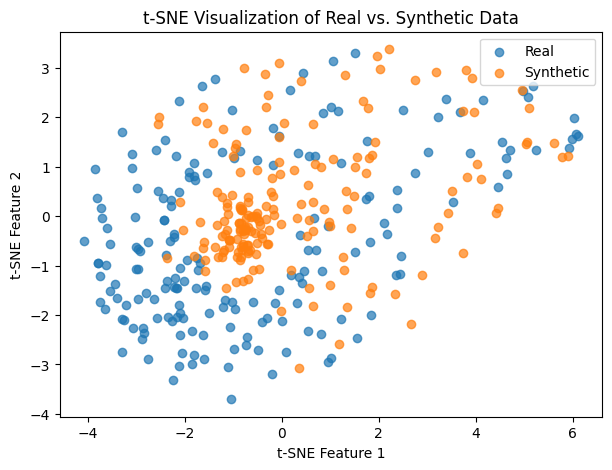

In [ ]:
# Create labels
labels = ['Real'] * len(df) + ['Synthetic'] * len(sdg)

# Visualization
plt.figure(figsize=(7, 5))
for label in ['Real', 'Synthetic']:
    indices = [i for i, l in enumerate(labels) if l == label]
    plt.scatter(tsne_results[indices, 0], tsne_results[indices, 1], label=label, alpha=0.7)
plt.title('t-SNE Visualization of Real vs. Synthetic Data')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
plt.show()

In [ ]:
!pip install wordcloud

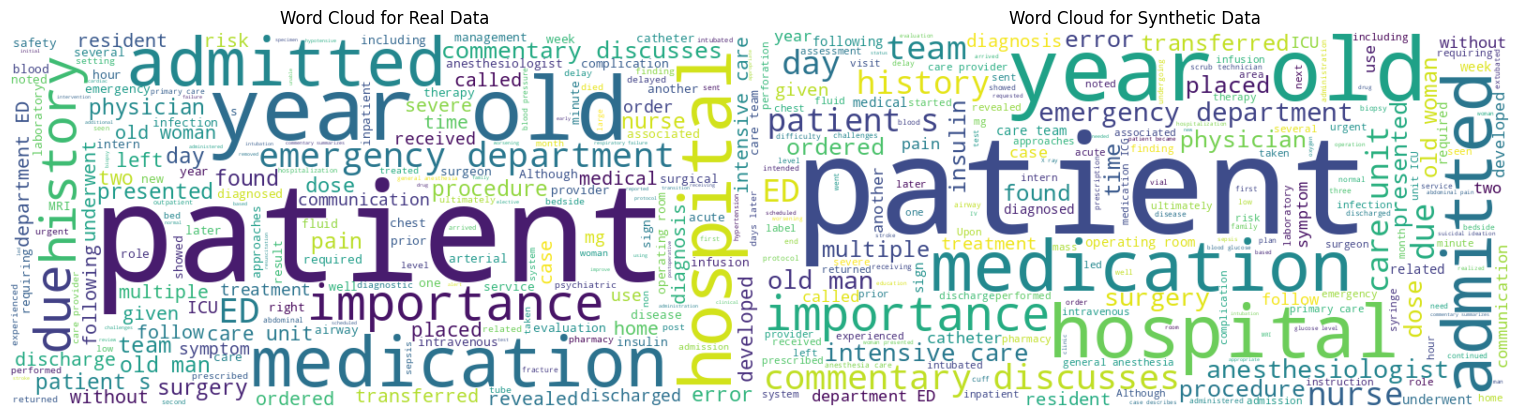

In [ ]:
from wordcloud import WordCloud

# Combine all text from the 'Case' column into single strings
text_real = ' '.join(df['Case'].dropna().values)
text_synth = ' '.join(sdg['Case'].dropna().values)

# Create word clouds
wordcloud_real = WordCloud(width=800, height=400, background_color='white').generate(text_real)
wordcloud_synth = WordCloud(width=800, height=400, background_color='white').generate(text_synth)

# Plot word clouds
plt.figure(figsize=(15, 10))

# Real data word cloud
plt.subplot(1, 2, 1)
plt.imshow(wordcloud_real, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Real Data')

# Synthetic data word cloud
plt.subplot(1, 2, 2)
plt.imshow(wordcloud_synth, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Synthetic Data')

plt.tight_layout(pad=0)
plt.show()

In [ ]:
sdg.to_csv('Synthetic_ME_Data.csv')